In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

In [3]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/visual-anomaly-detection-cnn")
sys.path.append(str(PROJECT_ROOT))

In [4]:
from src.patchcore_utils import (
    build_backbone,
    align_features,
    concatenate_features,
    extract_patches,
    build_memory_bank,
    compute_patch_score,
    image_anomaly_score,
    build_anomaly_map
)

In [5]:
from src.data_loader import (
    get_train_paths,
    get_test_paths,
    build_train_dataset,
    build_test_dataset
)

category = "bottle"

train_paths = get_train_paths(category)
test_paths, test_labels = get_test_paths(category)

train_ds = build_train_dataset(train_paths)
test_ds = build_test_dataset(test_paths, test_labels)
test_ds = test_ds.unbatch().batch(1)

In [6]:
backbone = build_backbone()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## image → backbone → features
## features → align → concat
## concat → patches → sample → memory bank

In [7]:
memory_bank = []
sampling_ratio = 0.07
for batch_x in train_ds:
    features = backbone(batch_x, training=False)
    aligned = align_features(features)
    concat_feat = concatenate_features(aligned)
    patches = extract_patches(concat_feat)
    patches = patches / tf.norm(patches, axis=1, keepdims=True)

    n = patches.shape[0]
    k = int(n * sampling_ratio)

    idx = np.random.choice(n, k, replace=False)
    sampled = patches.numpy()[idx]

    memory_bank.append(sampled)

memory_bank = np.concatenate(memory_bank, axis=0)
print("Memory bank shape:", memory_bank.shape)

Memory bank shape: (59917, 1792)


In [8]:
all_scores = []
all_labels = []

# Ensure memory bank is numpy
if isinstance(memory_bank, tf.Tensor):
    memory_bank = memory_bank.numpy()

print("Starting loop... if you don't see 'Processing', the dataset might be empty.")

for step, (batch_x, batch_y) in enumerate(test_ds):
    if step % 10 == 0:
        print(f"Processing image {step}...")

    features = backbone(batch_x, training=False)
    aligned = align_features(features)
    concat_feat = concatenate_features(aligned)

    patches = extract_patches(concat_feat)

    # Normalize
    patches = tf.nn.l2_normalize(patches, axis=1)

    # Compute scores
    patch_scores = compute_patch_score(
        patches.numpy(),
        memory_bank,
        batch_size = 1024
    )

    img_score = image_anomaly_score(patch_scores)

    all_scores.append(img_score)
    all_labels.append(batch_y.numpy()[0] if len(batch_y.shape) > 0 else batch_y.numpy())

print("Evaluation Complete.")


Starting loop... if you don't see 'Processing', the dataset might be empty.
Processing image 0...
Processing image 10...
Processing image 20...
Processing image 30...
Processing image 40...
Processing image 50...
Processing image 60...
Processing image 70...
Processing image 80...
Evaluation Complete.


In [9]:
label_np = np.array(all_labels)
score_np = np.array(all_scores)
auc = roc_auc_score(label_np, score_np)
print("AUC: ", auc)

AUC:  0.9023809523809525


In [10]:
import cv2
import matplotlib.pyplot as plt

def visualize_anomaly(image, anomaly_map):
    anomaly_map = cv2.resize(anomaly_map, (256, 256))
    anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())

    heatmap = cv2.applyColorMap(
        np.uint8(255 * anomaly_map), cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = 0.6 * image + 0.4 * heatmap
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(anomaly_map, cmap="jet")
    plt.title("Anomaly Map")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

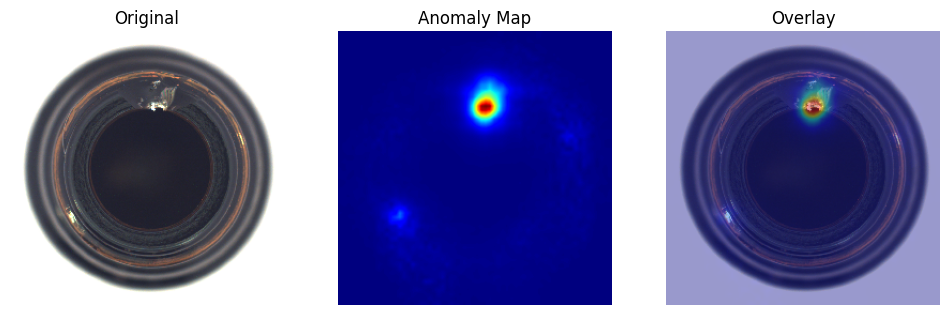

In [11]:
for batch_x, batch_y in test_ds:
    if batch_y.numpy()[0] == 1:   # anomaly image
        features = backbone(batch_x, training=False)
        aligned = align_features(features)
        concat_feat = concatenate_features(aligned)

        patches = extract_patches(concat_feat)
        patches = patches / tf.norm(patches, axis=1, keepdims=True)

        patch_scores = compute_patch_score(patches.numpy(), memory_bank)
        anomaly_map = build_anomaly_map(patch_scores)

        visualize_anomaly(
            (batch_x[0].numpy() * 255).astype(np.uint8),
            anomaly_map
        )
        break

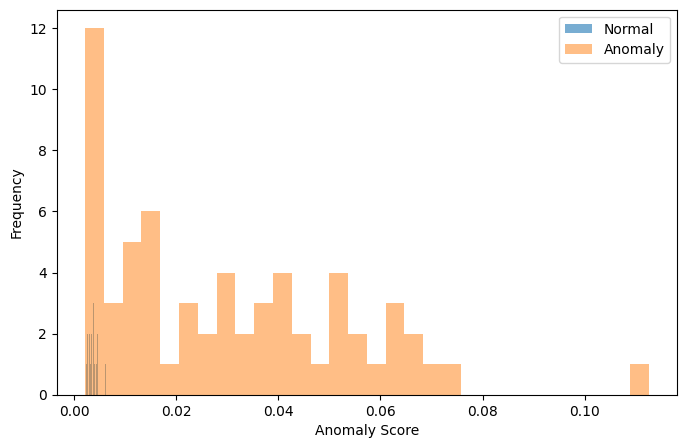

In [12]:
all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

plt.figure(figsize = (8,5))

plt.hist(
    all_scores[np.array(all_labels) == 0],
    bins = 30,
    alpha = 0.6,
    label = "Normal"
)

plt.hist(
    all_scores[np.array(all_labels) == 1],
    bins = 30,
    alpha = 0.5,
    label = "Anomaly"
)

plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

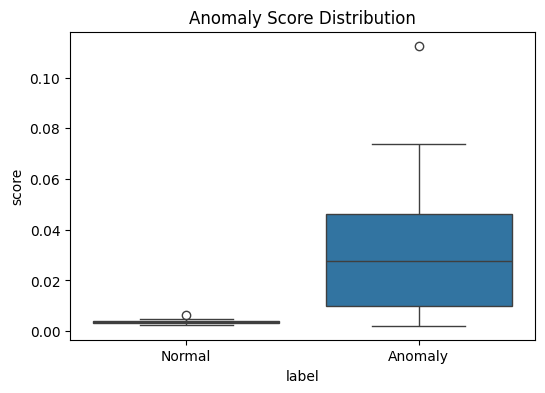

In [13]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({
    "score": all_scores,
    "label": ["Normal" if l==0 else "Anomaly" for l in all_labels]
})

plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="score", data=df)
plt.title("Anomaly Score Distribution")
plt.show()

Best Threshold : 0.0063


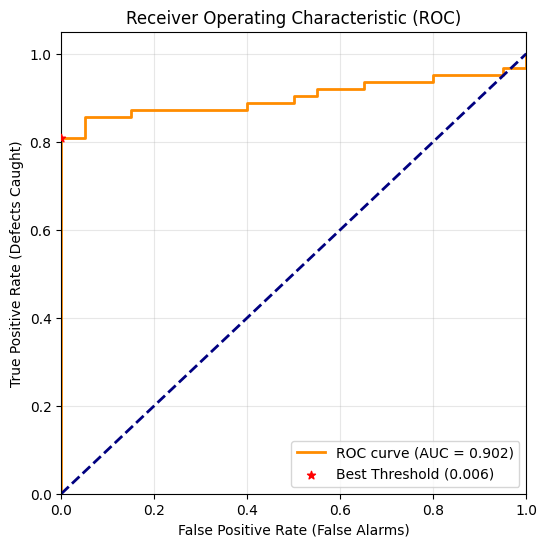

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Best Threshold : {optimal_threshold:.4f}")

plt.figure(figsize = (6,6))
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = f'ROC curve (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color = "navy", lw = 2, linestyle = "--")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='*', color = "red", zorder = 10, label = f'Best Threshold ({optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (False Alarms)')
plt.ylabel('True Positive Rate (Defects Caught)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

preds = (all_scores >= best_threshold).astype(int)
cm = confusion_matrix(all_labels, preds)
print(cm)

[[20  0]
 [12 51]]


## Project Summary
In this project, we implemented an industrial visual anomaly detection pipeline using the PatchCore algorithm. Leveraging pretrained CNN features from ResNet-50 and a non-parametric memory bank, the model detects both global and local defects without requiring anomaly samples during training.


## What I build:
	•	Dataset: MVTec Anomaly Detection (industrial objects)
	•	Backbone: ResNet-50 (ImageNet pretrained, frozen)
	•	Feature extraction: Multi-layer intermediate features
	•	Patch representation: Spatial patch embeddings (64×64 grid)
	•	Memory bank: Normal patch embeddings only
	•	Scoring: k-Nearest Neighbor distance in feature space
	•	Output:
	•	Image-level anomaly score
	•	Pixel-level anomaly heatmaps

## Why PatchCore

	•	Avoids reconstruction bias of Autoencoders
	•	Uses rich semantic features from pretrained CNNs
	•	Strong localization ability (pixel-level heatmaps)
	•	Proven SOTA method for industrial inspection


## Result

	•	ROC–AUC: ~0.90
	•	Clear separation between normal and anomalous scores
	•	Accurate localization of defects via anomaly heatmaps
	•	Robust decision threshold selected using ROC analysis


## Comparison with baseline (Autoencoder)
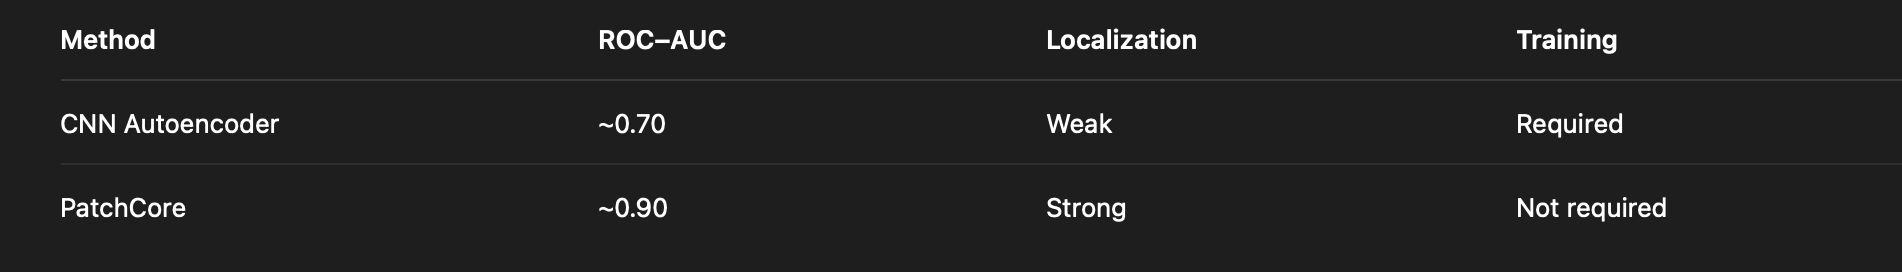


## Limitations

	•	Memory bank size grows with dataset
	•	kNN distance computation is expensive
	•	Threshold selection is class-dependent
	•	Backbone choice impacts performance

## Final Conclusion

This project demonstrates that pretrained CNN feature representations combined with non-parametric memory-based methods provide an effective and training-free solution for industrial anomaly detection. PatchCore achieves high detection accuracy and precise localization, making it suitable for real-world manufacturing quality inspection systems.